In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.feature_selection import RFECV
import xgboost as xgb
import lightgbm as lgb

In [2]:
train_df = pd.read_csv('./preprocessed_data/train_set.csv')

In [3]:
train_df.columns

Index(['game_id', 'club_id_x', 'club_id_y', 'B365HW', 'B365D', 'B365AW',
       'Table_x', 'Table_y', 'manager_name_x', 'manager_name_y',
       'home_team_id', 'Result', 'Referee', 'total_games_x', 'wins_x',
       'win_percentage_x', 'total_games_vs_opponent_x', 'wins_vs_opponent_x',
       'win_percentage_vs_opponent_x', 'TY_x', 'OY_x', 'TR_x', 'OR_x',
       'Possesion_x', 'Aerial Duels(%)_x', 'GF_x', 'GA_x', 'Shot on Target_x',
       'Shot on Target(%)_x', 'Goals per Shot_x', 'Expected Goals_x',
       'Save%_x', 'Clean Sheet_x', 'Pass Completion %_x', 'Assists_x',
       'Exp. Assisted Goals_x', 'Expected Assists_x', 'Tackles Won_x',
       '% of Dribblers Tackled_x', 'Blocks_x', 'Interceptions_x', 'Error_x',
       'market_value_in_eur_x', 'total_games_y', 'wins_y', 'win_percentage_y',
       'total_games_vs_opponent_y', 'wins_vs_opponent_y',
       'win_percentage_vs_opponent_y', 'TY_y', 'OY_y', 'TR_y', 'OR_y',
       'Possesion_y', 'Aerial Duels(%)_y', 'GF_y', 'GA_y', 'Shot o

In [4]:
# 전처리 

In [5]:
# 1. null 체크
# 앞에서 데이터를 합치는 과정에서 null값은 다 처리

In [6]:
# 2. 이상치 제거
# IQR 기반으로 데이터를 삭제하면 너무 많은 컬럼들이 삭제되므로 Z-Score를 기준으로 확인하여 삭제하기로 결정

In [7]:
# 히스토그램으로 데이터 확인

In [8]:
def get_4_hist(data:pd.DataFrame, columns:list):
    
    plt.figure(figsize=(15, 4 * (len(columns) // 4)))

    for i, col in enumerate(columns):
        plt.subplot(len(columns) // 4 + (len(columns) % 4 > 0), 4, i + 1)
        sns.histplot(data[col], kde=True)
        plt.title(col)

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()

In [9]:
distribution_check_col = ['B365HW', 'B365D', 'B365AW', 'total_games_x', 'wins_x', 'win_percentage_x', 
                          'total_games_vs_opponent_x', 'wins_vs_opponent_x', 'win_percentage_vs_opponent_x', 
                          'TY_x', 'OY_x', 'TR_x', 'OR_x', 'Possesion_x', 'Aerial Duels(%)_x', 'GF_x', 'GA_x', 
                          'Shot on Target_x', 'Shot on Target(%)_x', 'Goals per Shot_x', 'Expected Goals_x', 
                          'Save%_x', 'Clean Sheet_x', 'Pass Completion %_x', 'Assists_x', 'Exp. Assisted Goals_x', 
                          'Expected Assists_x', 'Tackles Won_x', '% of Dribblers Tackled_x', 'Blocks_x', 
                          'Interceptions_x', 'Error_x', 'market_value_in_eur_x', 'total_games_y', 'wins_y', 'win_percentage_y',
                          'total_games_vs_opponent_y', 'wins_vs_opponent_y', 'win_percentage_vs_opponent_y', 
                          'TY_y', 'OY_y', 'TR_y', 'OR_y', 'Possesion_y', 'Aerial Duels(%)_y', 'GF_y', 'GA_y', 'Shot on Target_y', 
                          'Shot on Target(%)_y', 'Goals per Shot_y', 'Expected Goals_y', 'Save%_y', 'Clean Sheet_y', 
                          'Pass Completion %_y', 'Assists_y', 'Exp. Assisted Goals_y', 'Expected Assists_y', 'Tackles Won_y', 
                          '% of Dribblers Tackled_y', 'Blocks_y', 'Interceptions_y', 'Error_y', 'market_value_in_eur_y']

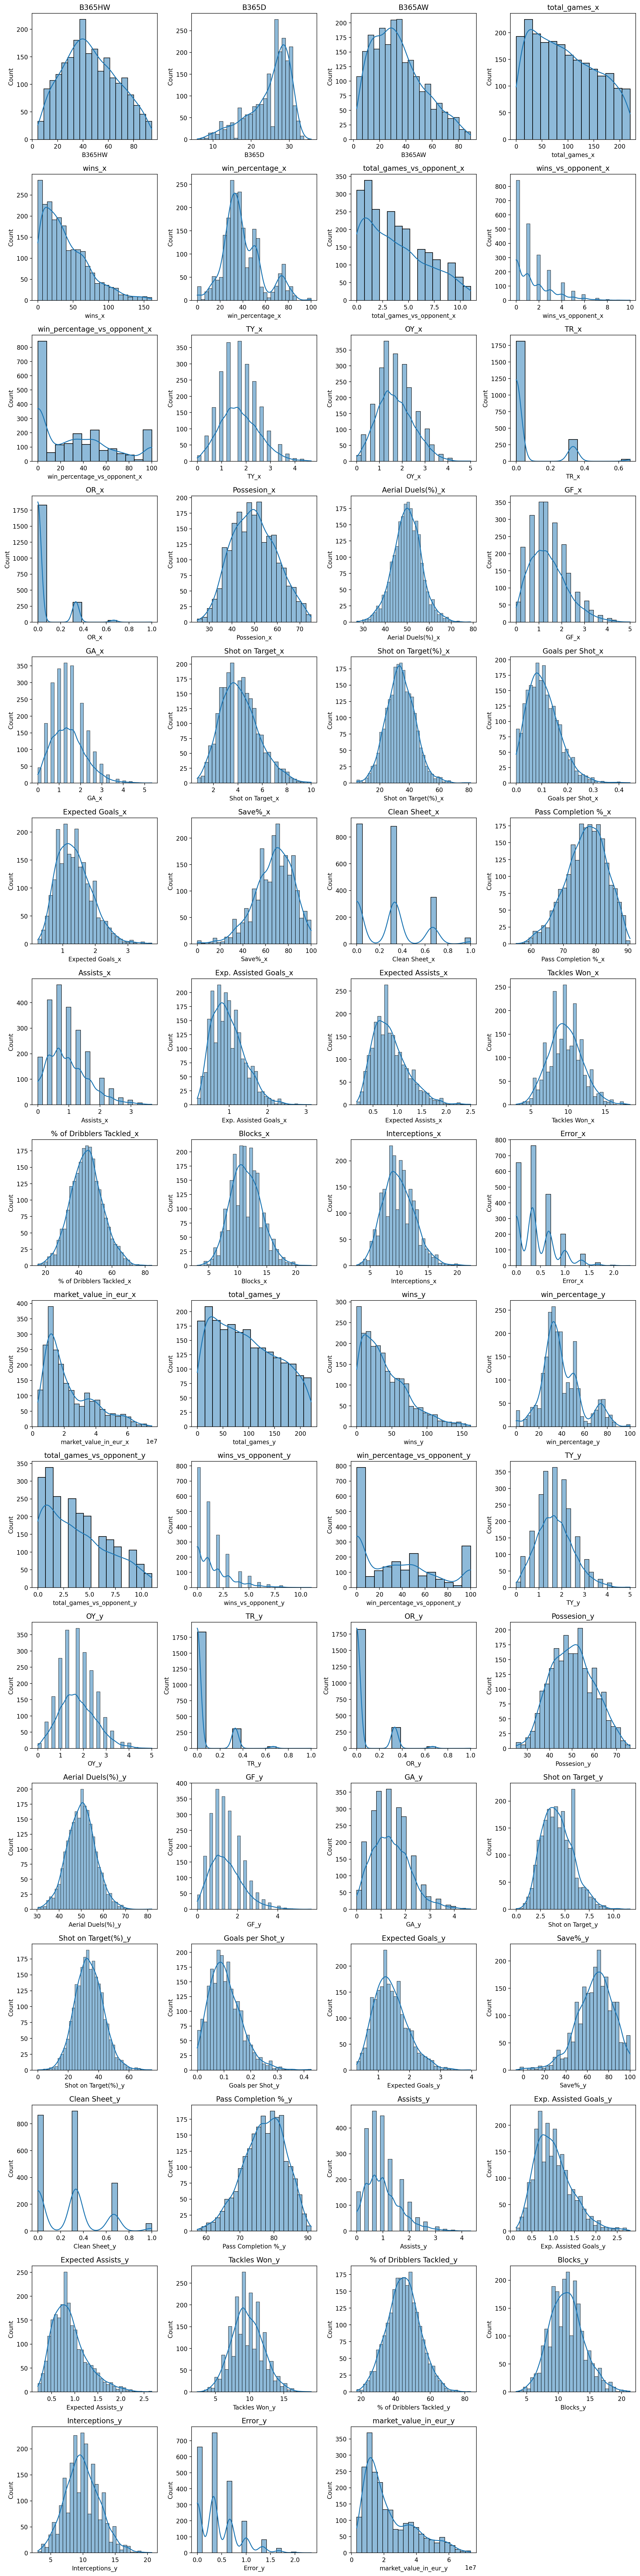

In [19]:
# 컬럼 분포 히스토그램으로 확인
get_4_hist(train_df, distribution_check_col)

In [10]:
# z-score를 계산하여 이상치가 있는지 확인하고 이상치를 제외한 데이터 반환
def remove_outliers(df, threshold):
    z_scores = (df - df.mean()) / df.std()
    no_outliers_df = df[(z_scores <= threshold) & (z_scores >= -threshold)]
    return no_outliers_df

In [11]:
# z-score 3, 4 의 경우 많은 수의 데이터를 삭제해야 해서 z-score 5를 기준으로 하여 이상치 제거
train_df[distribution_check_col] = train_df[distribution_check_col].apply(lambda x: remove_outliers(x, 5))

In [12]:
train_df = train_df.dropna()

In [13]:
# 15개 행 삭제됨
train_df

game_id  club_id_x  club_id_y     B365HW      B365D     B365AW  Table_x  \
0     3050217         11         29  69.444444  20.000000  13.333333        6   
1     3050227         11       1010  69.444444  19.607843  14.285714        5   
2     3050247         11       1003  65.359477  22.222222  15.384615        4   
3     3050267         11         31  25.641026  25.641026  51.282051        5   
4     3050277         11        543  60.240964  23.809524  19.047619        5   
...       ...        ...        ...        ...        ...        ...      ...   
2171  4095279       1237        543  60.606061  23.094688  20.000000        7   
2172  4095299       1237        873  58.823529  25.000000  21.052632        8   
2173  4095333       1237         29  54.644809  26.315789  23.809524        7   
2174  4095353       1237        703  55.555556  25.000000  25.000000        8   
2175  4095391       1237         11  20.000000  23.094688  61.728395       10   

      Table_y  manager_name_x  manager_name_y  ...  Pass Completion %_y  \
0          12              82              40  ...            77.633333   
1           6              82              32  ...            65.400000   
2          11              82              13  ...            78.266667   
3           3              82              36  ...            82.333333   
4          11              82              53  ...            78.300000   
...       ...             ...             ...  ...                  ...   
2171       11              67              25  ...            72.400000   
2172       14              67              68  ...            77.433333   
2173       15              67              73  ...            73.733333   
2174       17              67              53  ...            75.666667   
2175        1              67              49  ...            79.333333   

      Assists_y  Exp. Assisted Goals_y  Expected Assists_y  Tackles Won_y  \
0      1.333333               0.766667            0.866667      12.333333   
1      1.333333               0.766667            0.733333      12.000000   
2      1.333333               1.000000            0.900000      12.333333   
3      1.000000               0.800000            0.800000       8.666667   
4      0.000000               0.900000            0.733333       9.666667   
...         ...                    ...                 ...            ...   
2171   2.000000               1.200000            0.900000      13.000000   
2172   1.666667               0.733333            0.833333      10.666667   
2173   0.666667               1.200000            0.766667      15.000000   
2174   1.333333               1.866667            0.900000      10.333333   
2175   1.000000               0.766667            1.033333       6.000000   

      % of Dribblers Tackled_y   Blocks_y  Interceptions_y   Error_y  \
0                    50.566667   9.666667        10.000000  0.666667   
1                    52.166667  13.000000        16.000000  0.333333   
2                    47.633333  13.333333         9.333333  0.333333   
3                    49.700000  10.666667         8.000000  0.666667   
4                    39.900000  10.333333        13.000000  0.000000   
...                        ...        ...              ...       ...   
2171                 52.166667  12.666667        10.000000  0.666667   
2172                 56.933333  11.333333         7.666667  0.000000   
2173                 59.133333  13.333333        13.666667  0.000000   
2174                 57.000000  14.666667         8.000000  0.333333   
2175                 49.366667  10.666667         5.666667  0.333333   

      market_value_in_eur_y  
0              1.792857e+07  
1              7.142857e+06  
2              1.522344e+07  
3              4.684615e+07  
4              1.277381e+07  
...                     ...  
2171           1.643611e+07  
2172           1.926758e+07  
2173           1.680149e+07  
2174           1.668189e+07  
2175        

In [14]:
# 표준화

In [15]:
# 4. log 스케일링

In [16]:
# 값의 단위가 크고 약갼 좌측편향 되었던 'market_value_in_eur_x', 'market_value_in_eur_y' 2개의 컬럼만 log 스케일링 하기

skewed_col = ['market_value_in_eur_x', 'market_value_in_eur_y']

In [17]:
train_df[skewed_col] = np.log1p(train_df[skewed_col])

In [18]:
# 5. minmax scaling

In [19]:
# scaling할 컬럼

col_to_minmax = ['B365HW', 'B365D', 'B365AW',
       'total_games_x', 'wins_x',
       'win_percentage_x', 'total_games_vs_opponent_x', 'wins_vs_opponent_x',
       'win_percentage_vs_opponent_x', 'TY_x', 'OY_x', 'TR_x', 'OR_x',
       'Possesion_x', 'Aerial Duels(%)_x', 'GF_x', 'GA_x', 'Shot on Target_x',
       'Shot on Target(%)_x', 'Goals per Shot_x', 'Expected Goals_x',
       'Save%_x', 'Clean Sheet_x', 'Pass Completion %_x', 'Assists_x',
       'Exp. Assisted Goals_x', 'Expected Assists_x', 'Tackles Won_x',
       '% of Dribblers Tackled_x', 'Blocks_x', 'Interceptions_x', 'Error_x',
       'total_games_y', 'wins_y', 'win_percentage_y',
       'total_games_vs_opponent_y', 'wins_vs_opponent_y',
       'win_percentage_vs_opponent_y', 'TY_y', 'OY_y', 'TR_y', 'OR_y',
       'Possesion_y', 'Aerial Duels(%)_y', 'GF_y', 'GA_y', 'Shot on Target_y',
       'Shot on Target(%)_y', 'Goals per Shot_y', 'Expected Goals_y',
       'Save%_y', 'Clean Sheet_y', 'Pass Completion %_y', 'Assists_y',
       'Exp. Assisted Goals_y', 'Expected Assists_y', 'Tackles Won_y',
       '% of Dribblers Tackled_y', 'Blocks_y', 'Interceptions_y', 'Error_y']

In [20]:
# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

In [21]:
# 선택한 컬럼에 대해 스케일링 적용
train_df[col_to_minmax] = scaler.fit_transform(train_df[col_to_minmax])

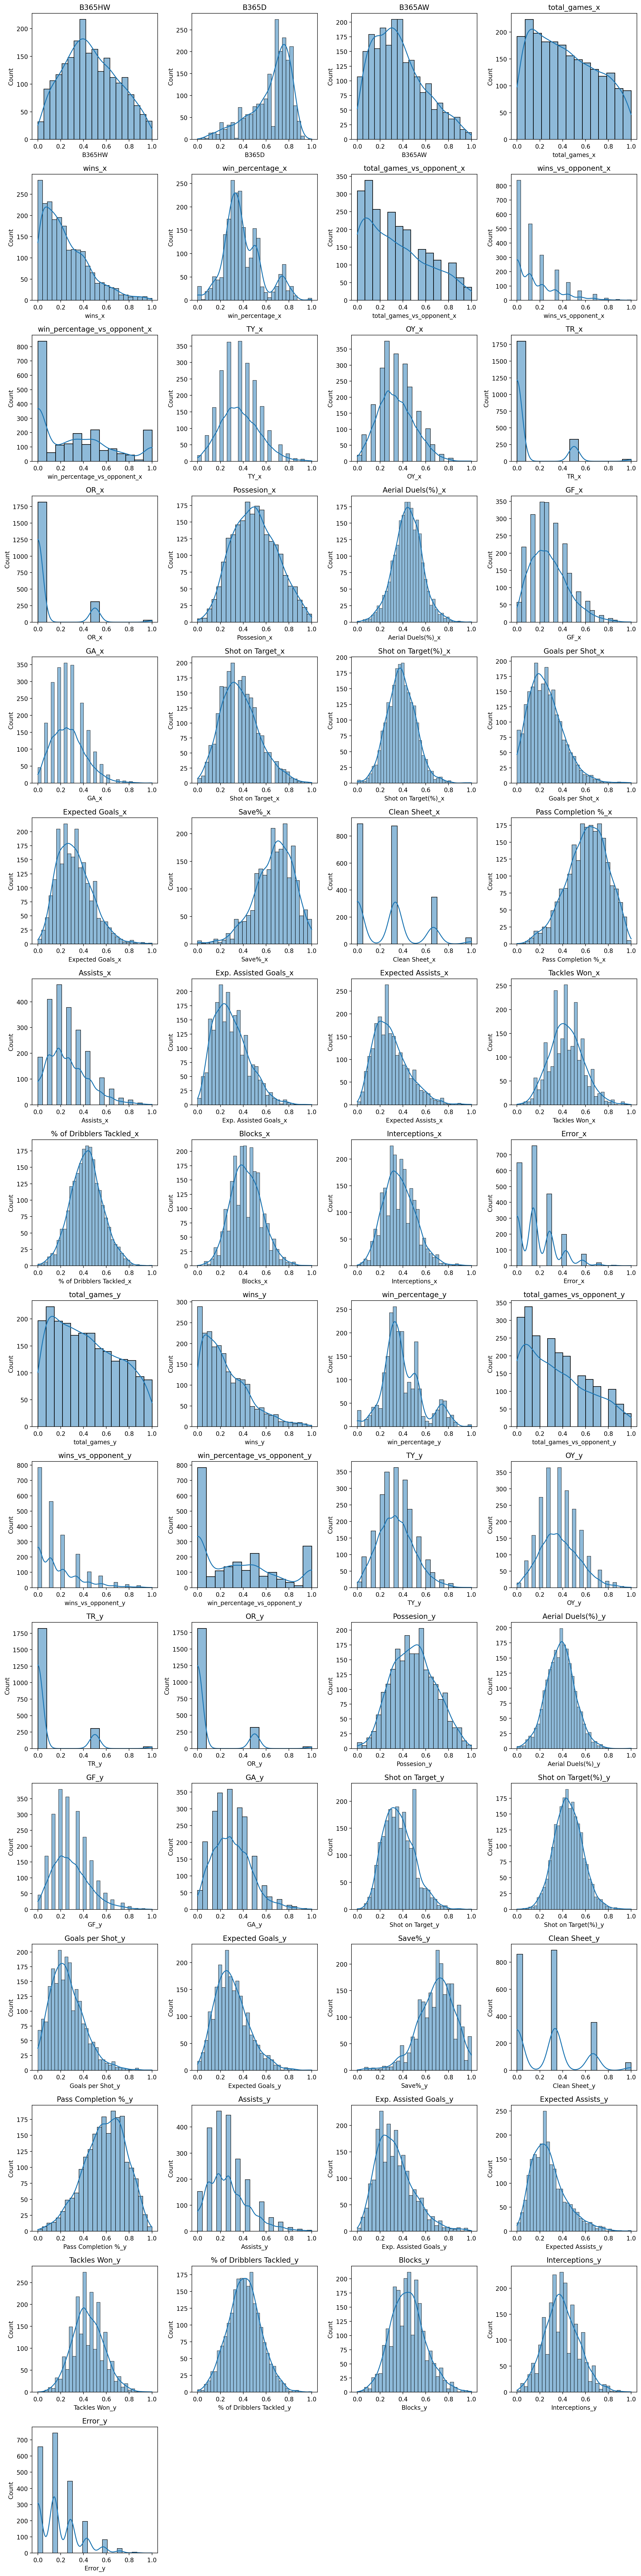

In [43]:
get_4_hist(train_df, col_to_minmax)

In [22]:
independent_variable = ['club_id_x', 'club_id_y', 'B365HW', 'B365D', 'B365AW',
       'Table_x', 'Table_y', 'manager_name_x', 'manager_name_y',
       'home_team_id', 'Referee', 'total_games_x', 'wins_x',
       'win_percentage_x', 'total_games_vs_opponent_x', 'wins_vs_opponent_x',
       'win_percentage_vs_opponent_x', 'TY_x', 'OY_x', 'TR_x', 'OR_x',
       'Possesion_x', 'Aerial Duels(%)_x', 'GF_x', 'GA_x', 'Shot on Target_x',
       'Shot on Target(%)_x', 'Goals per Shot_x', 'Expected Goals_x',
       'Save%_x', 'Clean Sheet_x', 'Pass Completion %_x', 'Assists_x',
       'Exp. Assisted Goals_x', 'Expected Assists_x', 'Tackles Won_x',
       '% of Dribblers Tackled_x', 'Blocks_x', 'Interceptions_x', 'Error_x',
       'market_value_in_eur_x', 'total_games_y', 'wins_y', 'win_percentage_y',
       'total_games_vs_opponent_y', 'wins_vs_opponent_y',
       'win_percentage_vs_opponent_y', 'TY_y', 'OY_y', 'TR_y', 'OR_y',
       'Possesion_y', 'Aerial Duels(%)_y', 'GF_y', 'GA_y', 'Shot on Target_y',
       'Shot on Target(%)_y', 'Goals per Shot_y', 'Expected Goals_y',
       'Save%_y', 'Clean Sheet_y', 'Pass Completion %_y', 'Assists_y',
       'Exp. Assisted Goals_y', 'Expected Assists_y', 'Tackles Won_y',
       '% of Dribblers Tackled_y', 'Blocks_y', 'Interceptions_y', 'Error_y',
       'market_value_in_eur_y']

In [23]:
# 데이터셋 train과 test로 나누기 : 시간이라는 변수를 추가하지 않아서 validation set을 최근 경기로 구성 

In [24]:
validation_set_game_id_list = [3838710, 3838704, 3838708, 3838706, 3838707, 3838702, 3838709,
       3838703, 3838701, 3838705, 3837992, 3837993, 3837988, 3838001,
       3837997, 3838747, 3838691, 3838694, 3838699, 3838692, 3838693,
       3838696, 3838698, 3838700, 3838697, 3838695, 3838675, 3838684,
       3838681, 3838679, 3838676, 3838678, 3838683, 3838677, 3838680,
       3838682, 3838674, 3838668, 3838672, 3838667, 3838670, 3838669,
       3838665, 3838673, 3838656, 3838653, 3838658, 3838649, 3838655,
       3838654, 3838651, 3838650, 3838652, 3838657, 3838645, 3838644,
       3838646, 3838640, 3838647, 3838643, 3838641, 3838639, 3838642,
       3838648, 3838716, 3838717, 3838714, 3838623, 3838631, 3838629,
       3838626, 3838627, 3838630, 3838628, 3838625, 3838632, 3838624,
       3838616, 3838621, 3838617, 3838622, 3838614, 3838619, 3838613,
       3838615, 3838618, 3838620, 3838748, 3838612, 3838603, 3838606,
       3838609, 3838605, 3838610, 3838607, 3838604, 3838611, 3838608,
       3838671, 3838666, 3838594, 3838597, 3838595, 3838602, 3838593,
       3838600, 3838598, 3838599, 3838601, 3838596, 4087924, 4087928,
       4087925, 4087926, 4087930, 4087927, 4087929, 4087932, 4087931,
       4087933, 4087940, 4087941, 4087936, 4087939, 4087937, 4087943,
       4087942, 4087934, 4087935, 4087949, 4087944, 4087951, 4087947,
       4087950, 4087946, 4087945, 4087953, 4087952, 4087948, 4087961,
       4087955, 4087958, 4087956, 4087957, 4087963, 4087962, 4087959,
       4087954, 4087960, 4087972, 4087968, 4087970, 4087973, 4087971,
       4087965, 4087967, 4087966, 4087964, 4087969, 4095069, 4095065,
       4095063, 4095067, 4095070, 4095068, 4095062, 4095066, 4095071,
       4095064, 4095140, 4095137, 4095136, 4095138, 4095143, 4095145,
       4095144, 4095142, 4095141, 4095139, 4087938, 4095151, 4095153,
       4095149, 4095148, 4095152, 4095150, 4095147, 4095155, 4095154,
       4095146, 4095158, 4095160, 4095156, 4095159, 4095162, 4095164,
       4095161, 4095163, 4095157, 4095165, 4095171, 4095170, 4095166,
       4095167, 4095175, 4095174, 4095172, 4095168, 4095169, 4095173,
       4095176, 4095181, 4095184, 4095177, 4095178, 4095179, 4095182,
       4095180, 4095183, 4095185, 4095187, 4095191, 4095193, 4095195,
       4095186, 4095190, 4095189, 4095188, 4095194, 4095192, 4095197,
       4095203, 4095196, 4095201, 4095202, 4095204, 4095200, 4095205,
       4095198, 4095199, 4095207, 4095214, 4095213, 4095208, 4095209,
       4095210, 4095206, 4095211, 4095215, 4095212, 4095223, 4095220,
       4095217, 4095224, 4095221, 4095219, 4095225, 4095216, 4095222,
       4095218, 4095235, 4095233, 4095227, 4095228, 4095226, 4095232,
       4095229, 4095231, 4095234, 4095230, 4095244, 4095239, 4095242,
       4095240, 4095243, 4095241, 4095237, 4095245, 4095238, 4095247,
       4095246, 4095252, 4095249, 4095250, 4095254, 4095248, 4095253,
       4095255, 4095256, 4095264, 4095260, 4095263, 4095265, 4095258,
       4095262, 4095261, 4095259, 4095257, 4095267, 4095275, 4095270,
       4095272, 4095271, 4095266, 4095268, 4095273, 4095269, 4095274,
       4095280, 4095281, 4095284, 4095283, 4095282, 4095277, 4095278,
       4095285, 4095276, 4095279, 4095288, 4095286, 4095289, 4095293,
       4095287, 4095295, 4095294, 4095290, 4095291, 4095292, 4095304,
       4095305, 4095302, 4095299, 4095300, 4095296, 4095301, 4095303,
       4095297, 4095298, 4095312, 4095316, 4095315, 4095313, 4095319,
       4095314, 4095317, 4095310, 4095318, 4095311, 4095320, 4095323,
       4095329, 4095327, 4095326, 4095321, 4095325, 4095324, 4095328,
       4095322, 4095251, 4095336, 4095331, 4095333, 4095335, 4095337,
       4095332, 4095330, 4095339, 4095338, 4095343, 4095347, 4095344,
       4095340, 4095342, 4095346, 4095349, 4095345, 4095341, 4095348,
       4095359, 4095355, 4095350, 4095357, 4095351, 4095358, 4095353,
       4095356, 4095352, 4095354, 4095236, 4095366, 4095362, 4095365,
       4095368, 4095373, 4095379, 4095377, 4095372, 4095378, 4095370,
       4095376, 4095371, 4095375, 4095374, 4095383, 4095384, 4095380,
       4095385, 4095387, 4095389, 4095381, 4095382, 4095386, 4095388,
       4095390, 4095395, 4095399, 4095393, 4095391, 4095392, 4095394,
       4095398, 4095396, 4095397]

In [25]:
validation_df = train_df[train_df['game_id'].isin(validation_set_game_id_list)]

In [26]:
final_train_df = train_df[~train_df['game_id'].isin(validation_set_game_id_list)]

In [27]:
X_train = final_train_df[independent_variable]
y_train = final_train_df['Result']

X_test = validation_df[independent_variable]
y_test = validation_df['Result']

In [28]:
X_train.shape, X_test.shape

((1746, 71), (415, 71))

In [23]:
# # 데이터셋 train과 test로 나누기
# X = train_df[independent_variable]
# y = train_df['Result']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### RandomForest

In [29]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # 트리 개수
    'max_depth': [None, 1, 2, 3, 4, 5, 6]     # 트리의 최대 깊이
}

rf_clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 테스트 세트를 사용하여 최종 평가
test_score = grid_search.score(X_test, y_test)

# 최적의 파라미터 및 스코어 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
print("Test Set Score:", test_score)

Fitting 4 folds for each of 28 candidates, totalling 112 fits
Best Parameters: {'max_depth': 1, 'n_estimators': 300}
Best Cross-Validation Score: 0.5011533495685764
Test Set Score: 0.5807228915662651


#### XGBoost

In [30]:
param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 1, 2, 3],
    'learning_rate': [0.05, 0.1, 0.2]
}

xgb_clf = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 테스트 세트를 사용하여 최종 평가
test_score = grid_search.score(X_test, y_test)

# 최적의 파라미터 및 스코어 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
print("Test Set Score:", test_score)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 50}
Best Cross-Validation Score: 0.5137326013478052
Test Set Score: 0.6048192771084338


#### GradientBoosting

In [31]:
param_grid = {
    'n_estimators': [70, 80, 100],
    'max_depth': [None, 1, 2],
    'learning_rate': [0.05, 0.07, 0.08, 0.1]
}

gb_clf = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 테스트 세트를 사용하여 최종 평가
test_score = grid_search.score(X_test, y_test)

# 최적의 파라미터 및 스코어 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
print("Test Set Score:", test_score)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 70}
Best Cross-Validation Score: 0.5005484642999601
Test Set Score: 0.6048192771084338


#### lightGBM

In [32]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 2],
    'learning_rate': [0.05, 0.06, 0.07, 0.1]
}

lgb_clf = lgb.LGBMClassifier(random_state=42)

grid_search = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 테스트 세트를 사용하여 최종 평가
test_score = grid_search.score(X_test, y_test)

# 최적의 파라미터 및 스코어 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
print("Test Set Score:", test_score)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6407
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 71
[LightGBM] [Info] Start training from score -1.493439
[LightGBM] [Info] Start training from score -0.824389
[LightGBM] [Info] Start training from score -1.087974
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6407
[Ligh

## feature selection

### feature importance

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6706
[LightGBM] [Info] Number of data points in the train set: 1746, number of used features: 71
[LightGBM] [Info] Start training from score -1.496375
[LightGBM] [Info] Start training from score -0.823901
[LightGBM] [Info] Start training from score -1.086657
Accuracy: 0.6120481927710844
F1 Score: 0.5465047382190121


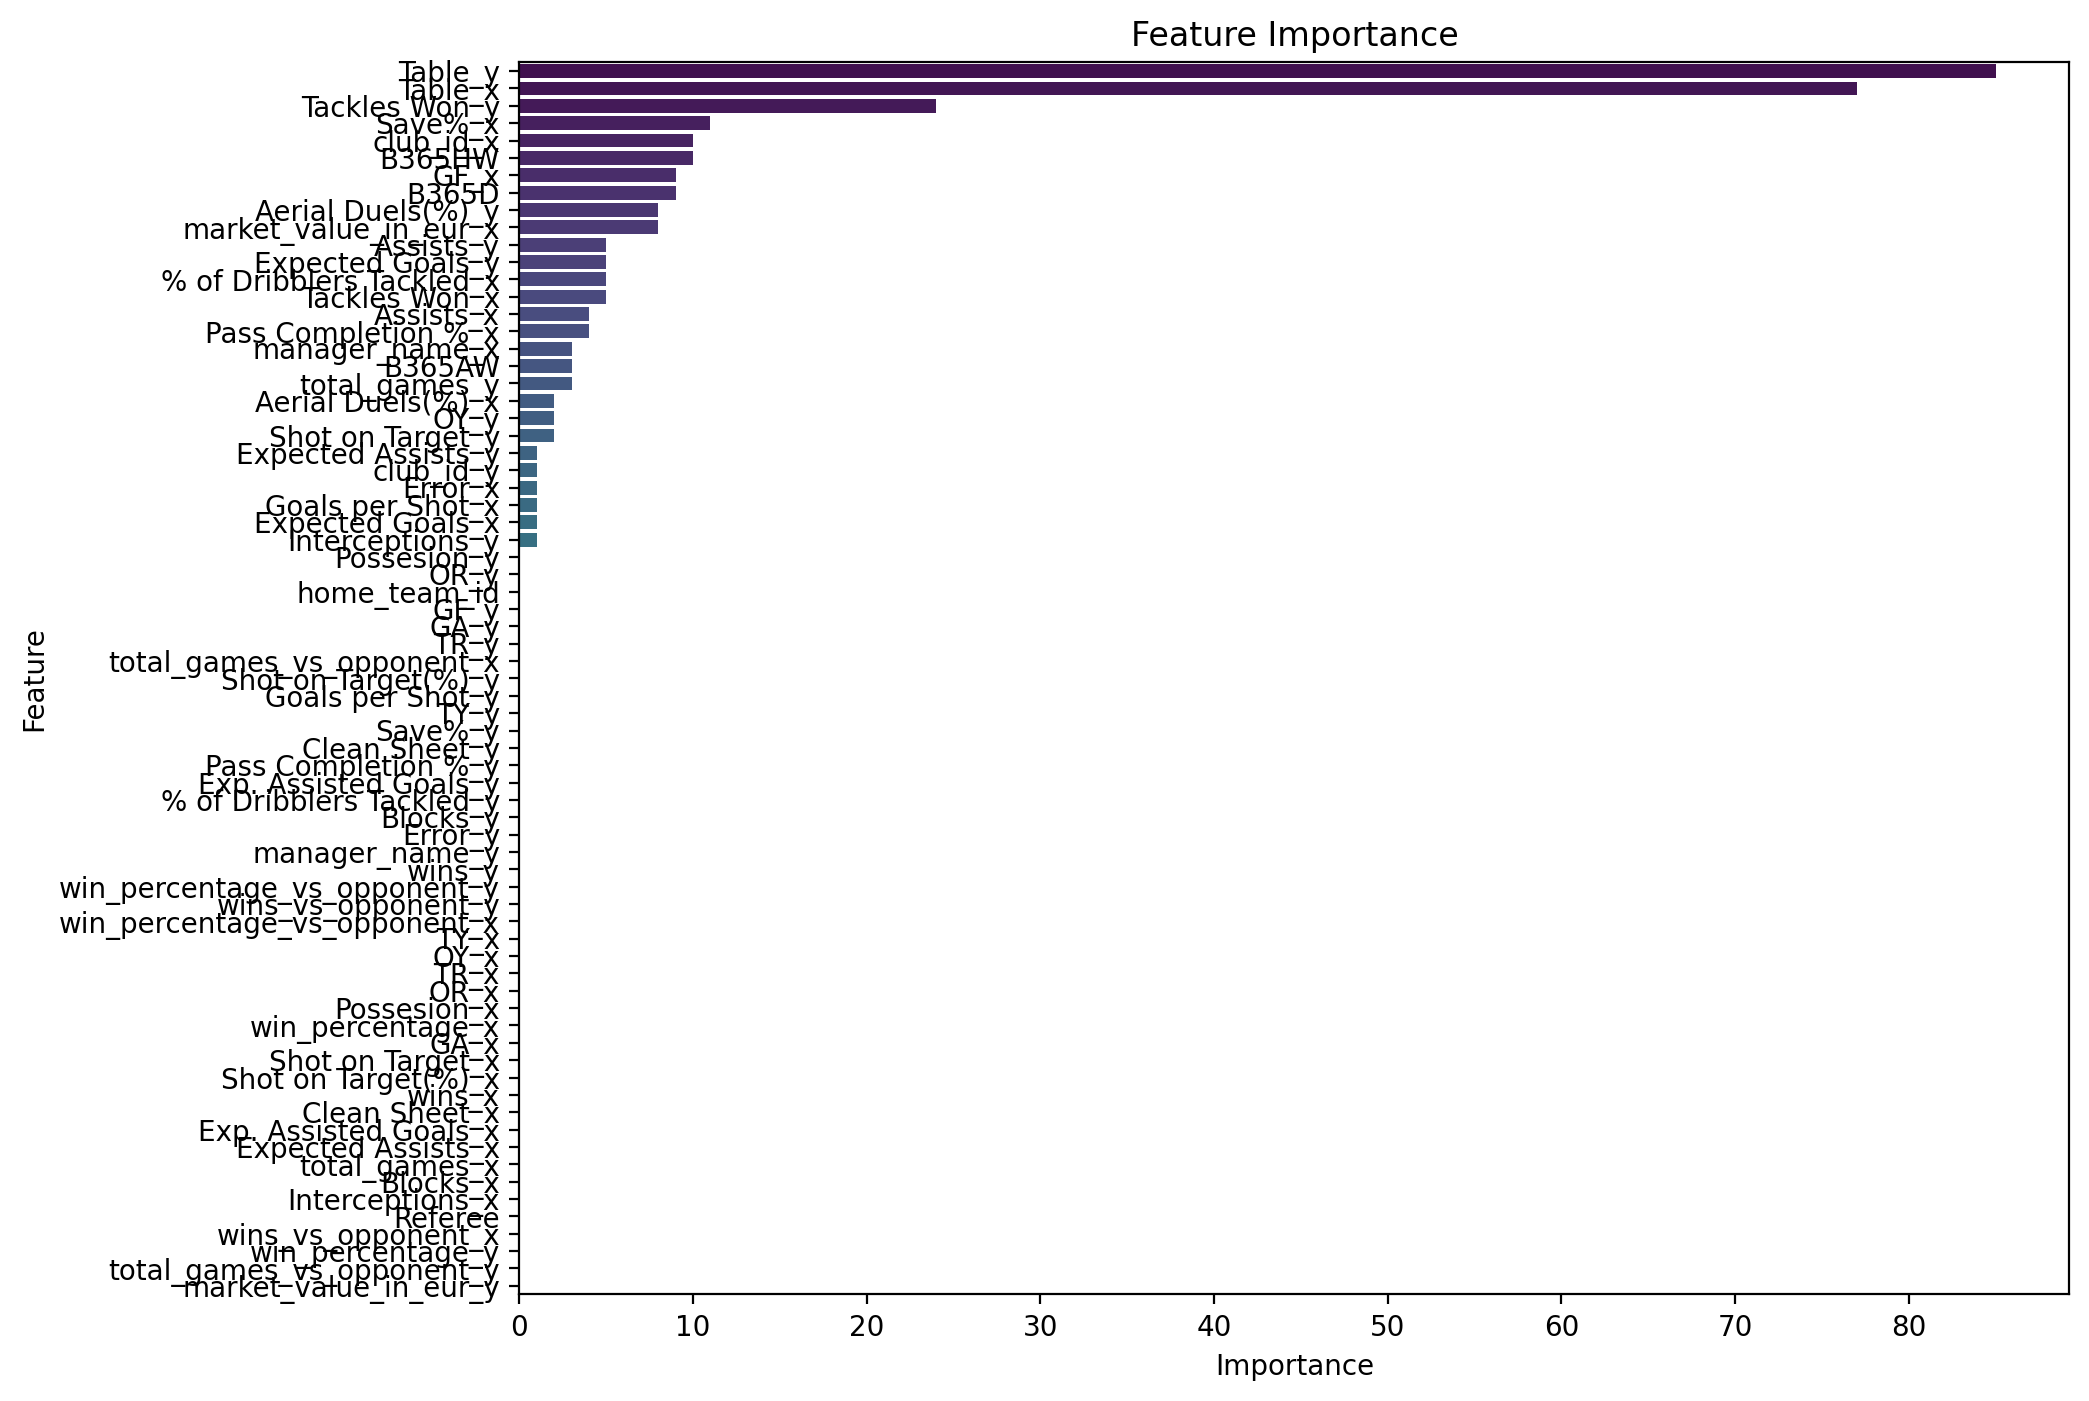

Feature Importance:
['Table_y', 'Table_x', 'Tackles Won_y', 'Save%_x', 'club_id_x', 'B365HW', 'GF_x', 'B365D', 'Aerial Duels(%)_y', 'market_value_in_eur_x', 'Assists_y', 'Expected Goals_y', '% of Dribblers Tackled_x', 'Tackles Won_x', 'Assists_x', 'Pass Completion %_x', 'manager_name_x', 'B365AW', 'total_games_y', 'Aerial Duels(%)_x', 'OY_y', 'Shot on Target_y', 'Expected Assists_y', 'club_id_y', 'Error_x', 'Goals per Shot_x', 'Expected Goals_x', 'Interceptions_y']


Feature  Importance
6                    Table_y          85
5                    Table_x          77
65             Tackles Won_y          24
29                   Save%_x          11
0                  club_id_x          10
2                     B365HW          10
23                      GF_x           9
3                      B365D           9
52         Aerial Duels(%)_y           8
40     market_value_in_eur_x           8
62                 Assists_y           5
58          Expected Goals_y           5
36  % of Dribblers Tackled_x           5
35             Tackles Won_x           5
32                 Assists_x           4
31       Pass Completion %_x           4
7             manager_name_x           3
4                     B365AW           3
41             total_games_y           3
22         Aerial Duels(%)_x           2
48                      OY_y           2
55          Shot on Target_y           2
64        Expected Assists_y           1
1                  club_id_y           1
39                   Error_x           1
27          Goals per Shot_x           1
28          Expected Goals_x           1
68           Interceptions_y           1

In [37]:
# LightGBM 모델 생성 및 학습
lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=1, learning_rate=0.06, random_state=42)
lgb_model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1) 

# 피처 중요도 확인
feature_importance = lgb_model.feature_importances_
feature_names = X_train.columns

# 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 중요도가 일정 값 이상인 피처 중요도와 해당 피처명 출력
print("Feature Importance:")
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0]  
print(feature_importance_df['Feature'].tolist())
feature_importance_df

Accuracy: 0.6144578313253012
F1 Score: 0.564654555971181


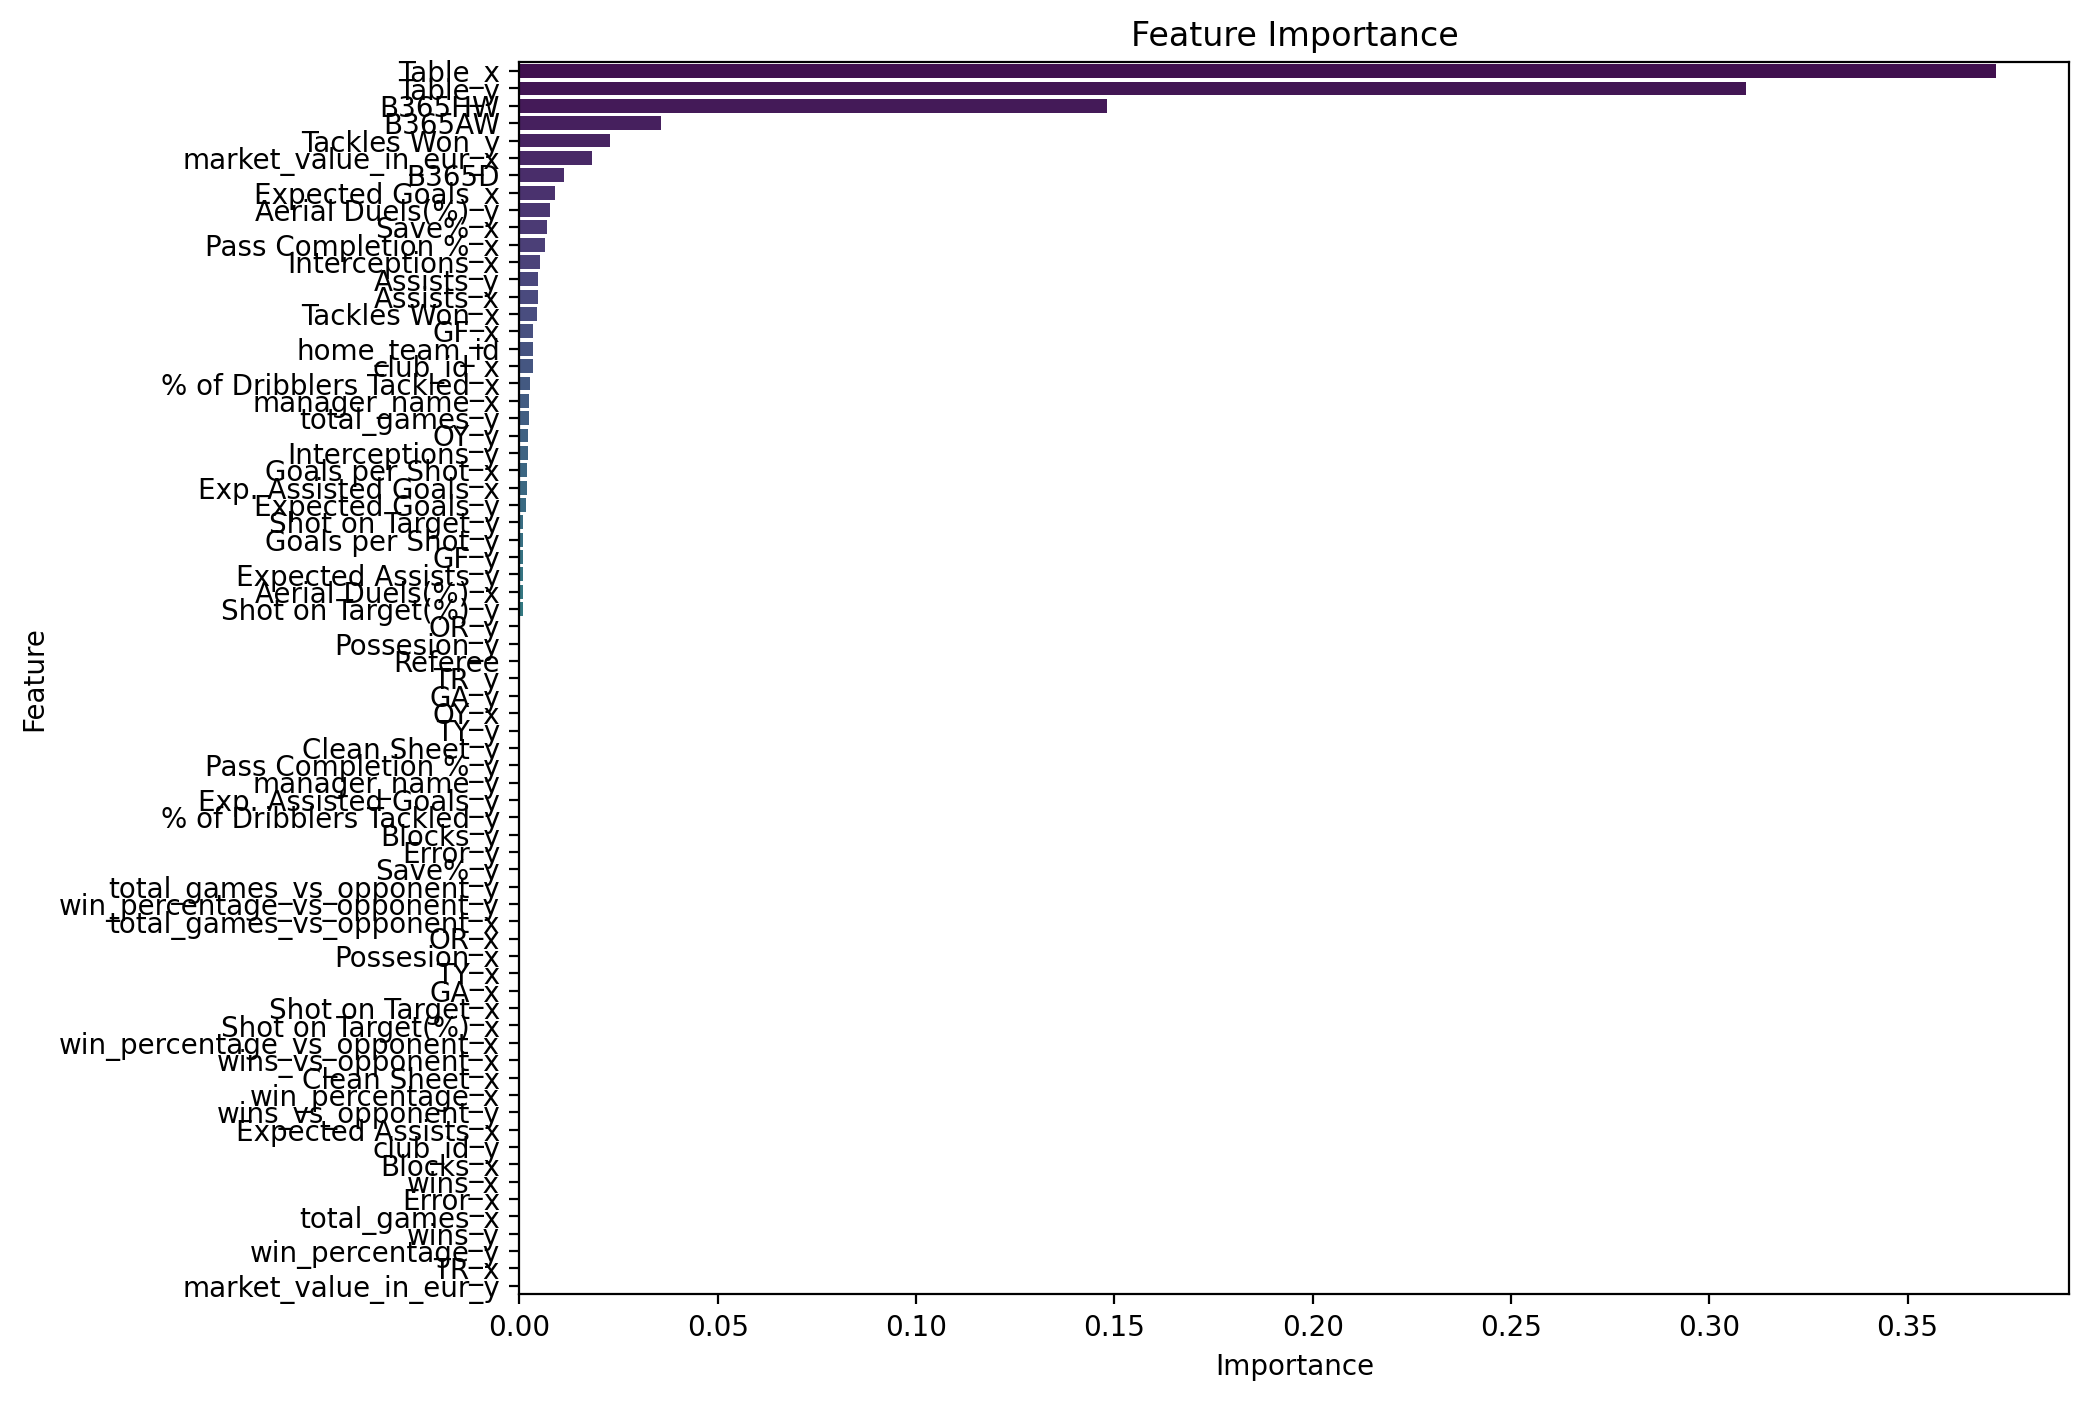

Feature Importance:
['Table_x', 'Table_y', 'B365HW', 'B365AW', 'Tackles Won_y', 'market_value_in_eur_x', 'B365D', 'Expected Goals_x', 'Aerial Duels(%)_y', 'Save%_x', 'Pass Completion %_x', 'Interceptions_x', 'Assists_y', 'Assists_x', 'Tackles Won_x', 'GF_x', 'home_team_id', 'club_id_x', '% of Dribblers Tackled_x', 'manager_name_x', 'total_games_y', 'OY_y', 'Interceptions_y', 'Goals per Shot_x', 'Exp. Assisted Goals_x', 'Expected Goals_y', 'Shot on Target_y', 'Goals per Shot_y', 'GF_y', 'Expected Assists_y', 'Aerial Duels(%)_x', 'Shot on Target(%)_y']


Feature  Importance
5                    Table_x    0.372193
6                    Table_y    0.309295
2                     B365HW    0.148131
4                     B365AW    0.035618
65             Tackles Won_y    0.022885
40     market_value_in_eur_x    0.018213
3                      B365D    0.011300
28          Expected Goals_x    0.008871
52         Aerial Duels(%)_y    0.007658
29                   Save%_x    0.006955
31       Pass Completion %_x    0.006355
38           Interceptions_x    0.005262
62                 Assists_y    0.004793
32                 Assists_x    0.004724
35             Tackles Won_x    0.004376
23                      GF_x    0.003534
9               home_team_id    0.003473
0                  club_id_x    0.003342
36  % of Dribblers Tackled_x    0.002781
7             manager_name_x    0.002450
41             total_games_y    0.002337
48                      OY_y    0.002190
68           Interceptions_y    0.002062
27          Goals per Shot_x    0.001999
33     Exp. Assisted Goals_x    0.001979
58          Expected Goals_y    0.001781
55          Shot on Target_y    0.000998
57          Goals per Shot_y    0.000992
53                      GF_y    0.000943
64        Expected Assists_y    0.000889
22         Aerial Duels(%)_x    0.000841
56       Shot on Target(%)_y    0.000780

In [39]:
# GradientBoosting 모델 생성 및 학습
gb_model = GradientBoostingClassifier(n_estimators=70, max_depth=1, random_state=42)
gb_model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1) 

# 피처 중요도 확인
feature_importance = gb_model.feature_importances_
feature_names = X_train.columns

# 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 중요도가 일정 값 이상인 피처 중요도와 해당 피처명 출력
print("Feature Importance:")
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0]  
print(feature_importance_df['Feature'].tolist())
feature_importance_df

Accuracy: 0.6096385542168675
F1 Score: 0.5510260889302235


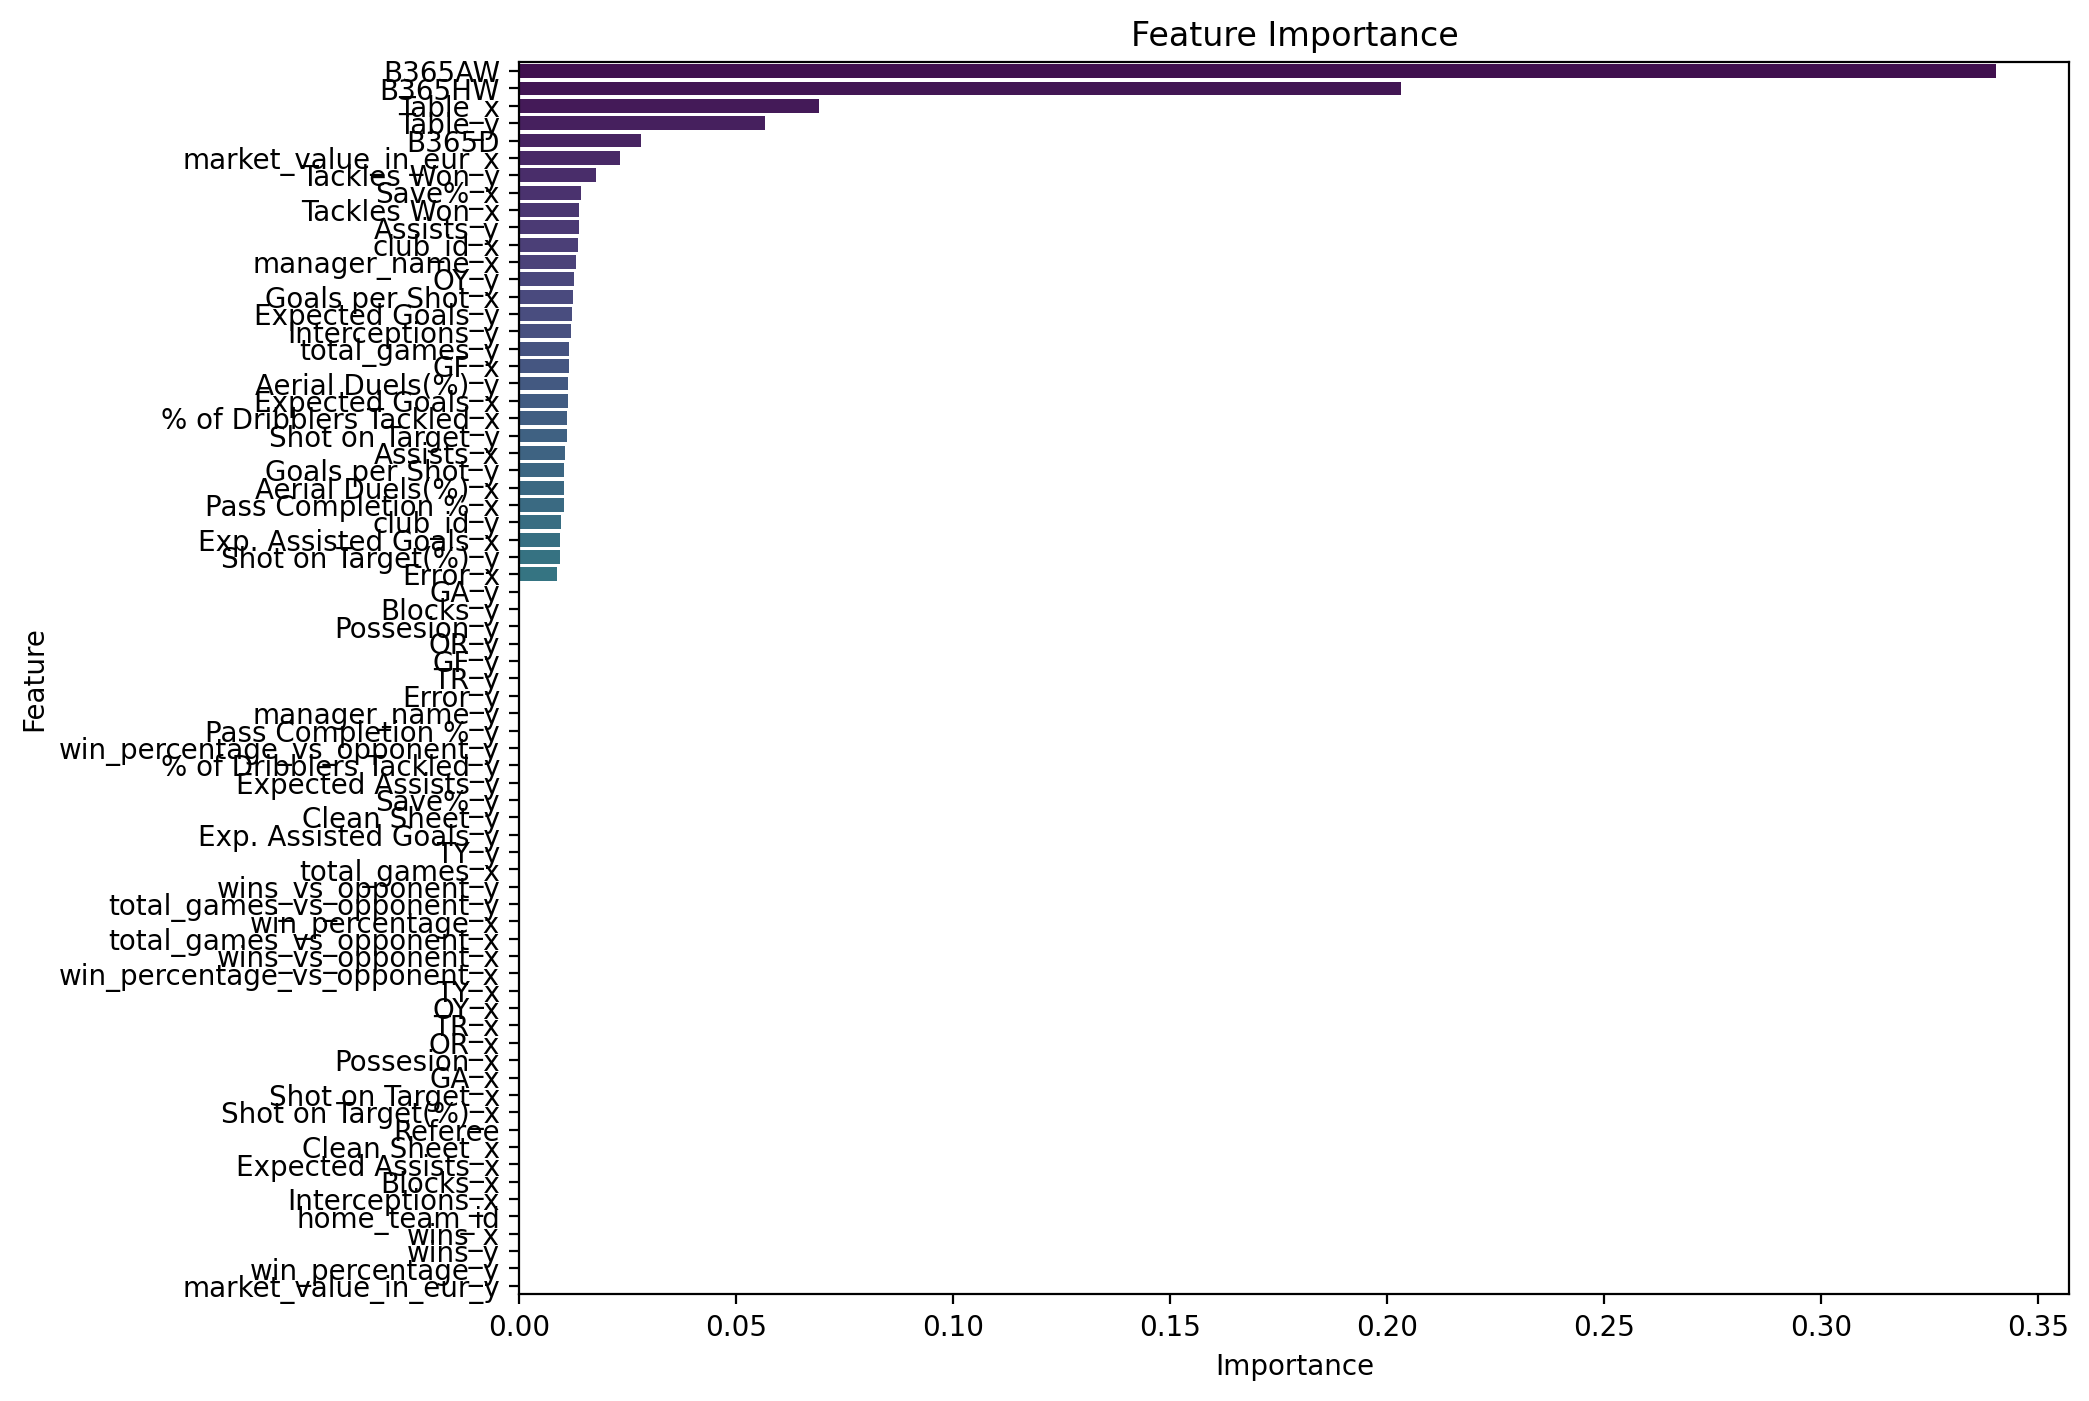

Feature Importance:
['B365AW', 'B365HW', 'Table_x', 'Table_y', 'B365D', 'market_value_in_eur_x', 'Tackles Won_y', 'Save%_x', 'Tackles Won_x', 'Assists_y', 'club_id_x', 'manager_name_x', 'OY_y', 'Goals per Shot_x', 'Expected Goals_y', 'Interceptions_y', 'total_games_y', 'GF_x', 'Aerial Duels(%)_y', 'Expected Goals_x', '% of Dribblers Tackled_x', 'Shot on Target_y', 'Assists_x', 'Goals per Shot_y', 'Aerial Duels(%)_x', 'Pass Completion %_x', 'club_id_y', 'Exp. Assisted Goals_x', 'Shot on Target(%)_y', 'Error_x']


Feature  Importance
4                     B365AW    0.340129
2                     B365HW    0.203096
5                    Table_x    0.068943
6                    Table_y    0.056612
3                      B365D    0.027955
40     market_value_in_eur_x    0.023125
65             Tackles Won_y    0.017637
29                   Save%_x    0.014085
35             Tackles Won_x    0.013802
62                 Assists_y    0.013692
0                  club_id_x    0.013468
7             manager_name_x    0.013009
48                      OY_y    0.012563
27          Goals per Shot_x    0.012293
58          Expected Goals_y    0.012220
68           Interceptions_y    0.011772
41             total_games_y    0.011456
23                      GF_x    0.011372
52         Aerial Duels(%)_y    0.011255
28          Expected Goals_x    0.011220
36  % of Dribblers Tackled_x    0.010964
55          Shot on Target_y    0.010963
32                 Assists_x    0.010601
57          Goals per Shot_y    0.010371
22         Aerial Duels(%)_x    0.010253
31       Pass Completion %_x    0.010200
1                  club_id_y    0.009473
33     Exp. Assisted Goals_x    0.009435
56       Shot on Target(%)_y    0.009269
39                   Error_x    0.008769

In [40]:
# XGBoost 모델 생성 및 학습
xgb_model = xgb.XGBClassifier(n_estimators=50, max_depth=1, learning_rate=0.2, random_state=42)
xgb_model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1) 

# 피처 중요도 확인
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 중요도가 일정 값 이상인 피처 중요도와 해당 피처명 출력
print("Feature Importance:")
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0]  
print(feature_importance_df['Feature'].tolist())
feature_importance_df

In [41]:
selected_feature = ['Table_x', 'Table_y', 'B365HW', 'B365AW', 'Tackles Won_y', 'market_value_in_eur_x', 
                    'B365D', 'Expected Goals_x', 'Aerial Duels(%)_y', 'Save%_x', 'Pass Completion %_x', 
                    'Interceptions_x', 'Assists_y', 'Assists_x', 'Tackles Won_x', 'GF_x', 'home_team_id', 
                    'club_id_x', '% of Dribblers Tackled_x', 'manager_name_x', 'total_games_y', 'OY_y', 
                    'Interceptions_y', 'Goals per Shot_x', 'Exp. Assisted Goals_x', 'Expected Goals_y', 
                    'Shot on Target_y', 'Goals per Shot_y', 'GF_y', 'Expected Assists_y', 'Aerial Duels(%)_x', 
                    'Shot on Target(%)_y']

In [42]:
len(selected_feature)

32

In [44]:
gb_model = GradientBoostingClassifier(n_estimators=70, max_depth=1, random_state=42)
gb_model.fit(X_train[selected_feature], y_train)

# 테스트 데이터로 예측
y_pred = gb_model.predict(X_test[selected_feature])
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.6144578313253012
F1 Score: 0.564654555971181


In [47]:
# GradientBoostingClassifier 모델 생성
gb_model = GradientBoostingClassifier(n_estimators=70, max_depth=1, random_state=42)

# 선택된 특성을 하나씩 제거하면서 성능을 평가
for i in range(len(selected_feature)-1, 0, -1):
    reduced_feature_set = selected_feature[:i]
    
    # 모델 학습
    gb_model.fit(X_train[reduced_feature_set], y_train)
    
    # 테스트 데이터로 예측
    y_pred = gb_model.predict(X_test[reduced_feature_set])
    
    # 정확도 및 F1 스코어 계산
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 결과 출력
    print("selected Feature:", reduced_feature_set)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print()


selected Feature: ['Table_x', 'Table_y', 'B365HW', 'B365AW', 'Tackles Won_y', 'market_value_in_eur_x', 'B365D', 'Expected Goals_x', 'Aerial Duels(%)_y', 'Save%_x', 'Pass Completion %_x', 'Interceptions_x', 'Assists_y', 'Assists_x', 'Tackles Won_x', 'GF_x', 'home_team_id', 'club_id_x', '% of Dribblers Tackled_x', 'manager_name_x', 'total_games_y', 'OY_y', 'Interceptions_y', 'Goals per Shot_x', 'Exp. Assisted Goals_x', 'Expected Goals_y', 'Shot on Target_y', 'Goals per Shot_y', 'GF_y', 'Expected Assists_y', 'Aerial Duels(%)_x']
Accuracy: 0.619277108433735
F1 Score: 0.5680284492736987

selected Feature: ['Table_x', 'Table_y', 'B365HW', 'B365AW', 'Tackles Won_y', 'market_value_in_eur_x', 'B365D', 'Expected Goals_x', 'Aerial Duels(%)_y', 'Save%_x', 'Pass Completion %_x', 'Interceptions_x', 'Assists_y', 'Assists_x', 'Tackles Won_x', 'GF_x', 'home_team_id', 'club_id_x', '% of Dribblers Tackled_x', 'manager_name_x', 'total_games_y', 'OY_y', 'Interceptions_y', 'Goals per Shot_x', 'Exp. Assisted

#### 제일 성능이 좋은 feature 조합

In [ ]:
# selected Feature: ['Table_x', 'Table_y', 'B365HW', 'B365AW', 'Tackles Won_y', 'market_value_in_eur_x', 'B365D', 'Expected Goals_x']
# Accuracy: 0.6289156626506024
# F1 Score: 0.5669897927162024

#### RFECV

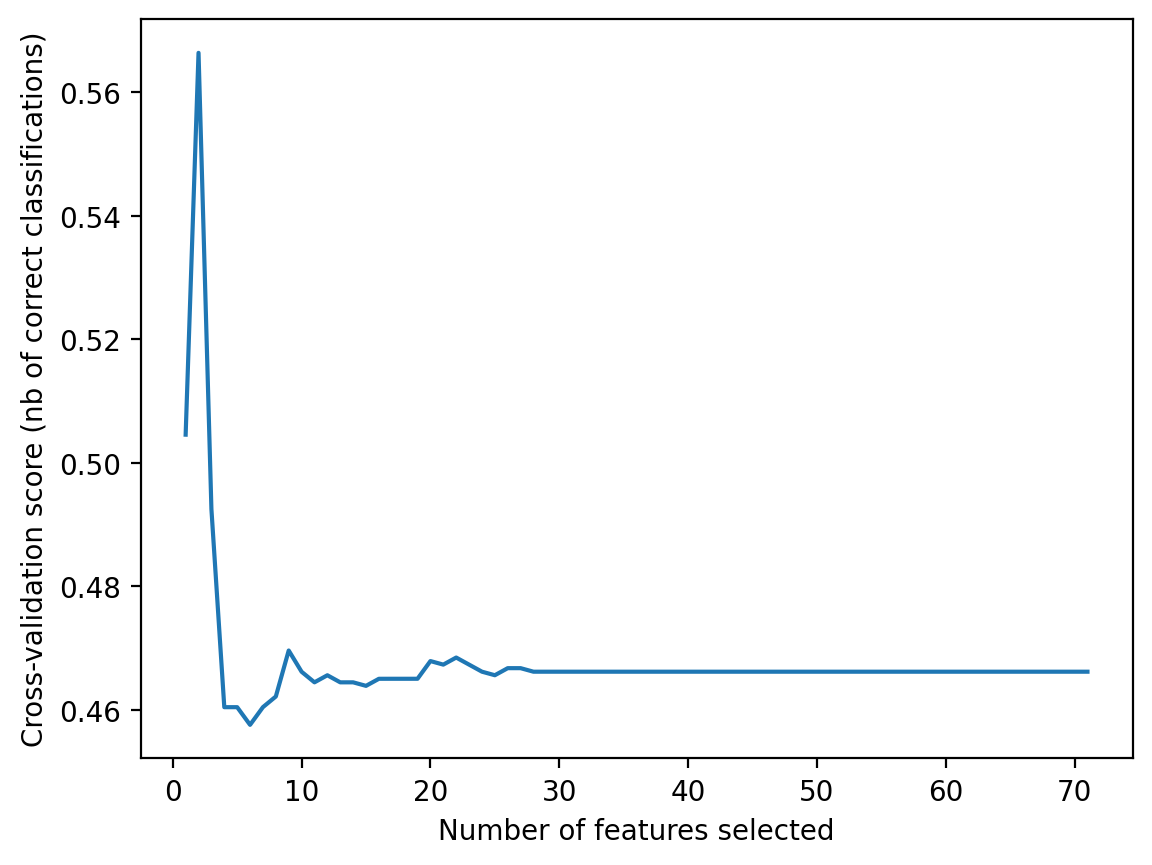

Selected features: Index(['Table_x', 'Table_y'], dtype='object')


In [50]:
gb_model = GradientBoostingClassifier(n_estimators=70, max_depth=1, random_state=42)

# RFECV 객체 생성
selector = RFECV(estimator=gb_model, step=1, cv=4, scoring='accuracy')

# 모델 훈련 
selector = selector.fit(X_train, y_train)

# 선택된 특성 수에 따른 교차 검증 점수 시각화
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.show()

# 선택된 특성 확인
selected_feature = X_train.columns[selector.support_]
print("Selected features:", selected_feature)


In [51]:
rfecv_selected_feature = ['Table_x', 'Table_y']

In [52]:
gb_model = GradientBoostingClassifier(n_estimators=70, max_depth=1, random_state=42)
gb_model.fit(X_train[rfecv_selected_feature], y_train)

# 테스트 데이터로 예측
y_pred = gb_model.predict(X_test[rfecv_selected_feature])
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.6072289156626506
F1 Score: 0.5484277698782786


### feature importance로 했을 때 미세하게 평균 정확도가 높아서 feature importance에서 나온 컬럼 사용하기로 함